In [324]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import h5py
import os
import seaborn as sns
from pyscf.scf.uhf import det_ovlp

# Testing in parallel code

In [378]:
filename = "he_vmc_cas_5_nelecas_1_1.hdf5"
f = h5py.File(filename, "r")

In [379]:
f.keys()

<KeysViewHDF5 ['acceptance', 'block', 'configs', 'energycorr', 'energyee', 'energyei', 'energygrad2', 'energyii', 'energyka', 'energykb', 'energyke', 'energytotal', 'energyvh', 'energyvxc', 'excitationsdelta', 'excitationsovlp_ij', 'nconfig']>

In [380]:
def plot_delta_ovlp(filename="abvmc.hdf5", discard = 2):
    f = h5py.File(filename, "r")    

    fig, ax = plt.subplots(3, 2, figsize = (12, 15))    
    ovlp_ij_raw=np.array(f['excitationsovlp_ij'])
    delta_ij_raw=np.array(f['excitationsdelta'])
    discard = 2
    ovlp_ij = np.average(ovlp_ij_raw[discard:], axis=0)
    # plt.figure()
    sns.heatmap(ovlp_ij, ax=ax[0, 0]) #, annot=True)
    ax[0, 0].set_title('Overlap matrix')
    # plt.title('Overlap matrix')

    ovlp_ij_std = np.std(ovlp_ij_raw[discard:], axis=0)
    sns.heatmap(ovlp_ij_std, ax=ax[1, 0]) #, annot=True)
    ax[1, 0].set_title('Standard deviation of overlap matrix')
    
    filtered_ovlp_ij = copy.deepcopy(ovlp_ij)
    filtered_ovlp_ij[ovlp_ij_std>np.abs(ovlp_ij)] = 0
    sns.heatmap(filtered_ovlp_ij, ax=ax[2, 0]) #, annot=True)
    ax[2, 0].set_title('Filtered overlap matrix')
    


    delta_ij = np.average(delta_ij_raw[discard:], axis=0)
    sns.heatmap(delta_ij, ax=ax[0, 1]) #, annot=True)
    ax[0, 1].set_title('Delta matrix')
                       
    delta_ij_std = np.std(delta_ij_raw[discard:], axis=0)
    sns.heatmap(delta_ij_std, ax=ax[1, 1]) #, annot=True)
    ax[1, 1].set_title('Standard deviation of delta matrix')
    

    filtered_delta_ij = copy.deepcopy(delta_ij)
    filtered_delta_ij[delta_ij_std>np.abs(delta_ij)] = 0
    sns.heatmap(filtered_delta_ij, ax=ax[2, 1]) #, annot=True)
    ax[2, 1].set_title('Filtered Delta matrix')
    
    return {'filtered': [filtered_ovlp_ij, filtered_delta_ij], 
            'raw': [ovlp_ij_raw, delta_ij_raw]}
# res = plot_delta_ovlp()

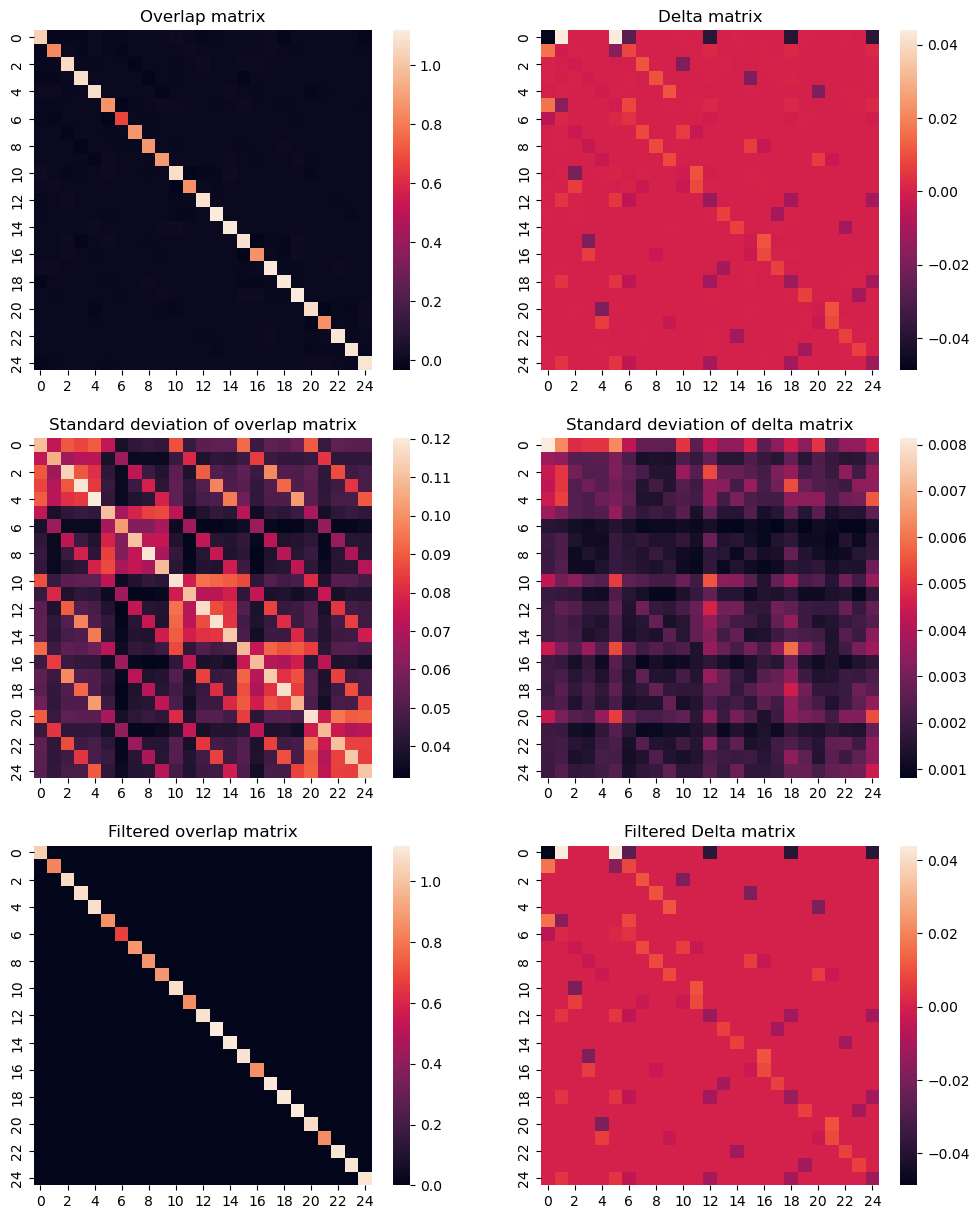

In [381]:
res = plot_delta_ovlp(filename, discard=0)
s, delta = res['filtered']
# sinv = np.linalg.inv(s)
# m = np.matmul(sinv, delta)
# e, v = np.linalg.eigh(m)
# (e-e[0]) * 27.211

In [389]:
# s, delta = res['raw']
# s[:, 0,0]
# delta[:, 0,0]

In [423]:
def get_h_mf(ci_filename, 
             ncore = (1,1), 
             target_root = 0, 
            compare_functional = 'pbe0'):
    f = h5py.File(ci_filename, "r")    
    ci = np.array(f['ci']['ci'][target_root])
    ncas = np.int32(f['ci']['ncas'])
    nelecas = list(np.array(f['ci']['nelecas']))
    try:
        ncore = list(np.array(f['ci']['ncore']))
    except:
        ncore = np.array(f['ci']['ncore'])
    print('Ncore: ', ncore)
    mo_coeff = np.array(f['ci']['mo_coeff'])
    # mc_mo_energy = np.array(f['ci']['mc_mo_energy'])
    mf_mo_energy = np.array(f['ci']['mf_mo_energy'])
    if compare_functional is not None:
        from pyscf import gto, scf, tools, dft
        mol = gto.M(atom="He 0. 0. 0.", basis="ccpvqz", unit='bohr')    
        mf = mol.UKS()
        mf.xc = 'pbe0'
        mf.kernel()
        xc_mo_energy = mf.mo_energy
    f.close()
    import pyscf
    import determinant_tools

    deters = pyscf.fci.addons.large_ci(ci, ncas, nelecas, tol=-1)
    det = determinant_tools.reformat_binary_dets(deters, ncore=ncore, tol=-1)
    ncore = (ncore-1, ncore-1)
    mf_levels = []
    xc_levels = []
    for d in det:
        c_i, orb_i = d
        orb_up = np.array(orb_i[0])
        orb_up = orb_up[orb_up>ncore[0]]
        orb_dn = np.array(orb_i[1])
        orb_dn = orb_dn[orb_dn>ncore[1]]
        mf_energy = np.sum(mf_mo_energy[0][orb_up]) + np.sum(mf_mo_energy[1][orb_dn])
        if compare_functional is not None:
            xc_energy = np.sum(xc_mo_energy[0][orb_up]) + np.sum(xc_mo_energy[1][orb_dn])  
            xc_levels.append(xc_energy)
        mf_levels.append(mf_energy)
        # print(orb_up, orb_dn, mf_energy)
        # print(orb_i)
    d = {}
    d['mo_energy'] = mf_mo_energy
    if compare_functional is not None:
        d['xc_energy'] = mf_mo_energy
        d['xc_levels'] = xc_levels
    return np.diag(mf_levels), d

def get_sigma(ci_filename, res, compare_functional=None):
    h_mf, d = get_h_mf(ci_filename, target_root = 0, compare_functional=compare_functional)    
    s, delta = res['filtered']
    sigma = np.matmul(np.linalg.inv(s), delta)
    fig, ax = plt.subplots(1, 2, figsize = (10,3))    
    # fig, ax = plt.subplots(3, 2, figsize = (12, 15))    
    sns.heatmap(sigma, ax=ax[0])
    ax[0].set_title('Sigma matrix')
    
    sns.heatmap(h_mf, ax=ax[1])
    ax[1].set_title('Hmf matrix')

    abvmc_eig, abvmc_eigv = np.linalg.eig(h_mf + sigma)
    abvmc_eig = np.sort(abvmc_eig)
    dft_eig = np.sort(np.diag(h_mf))    
    # dft_eig = np.diag(h_mf)
    return abvmc_eig, dft_eig, d
    

Ncore:  0
converged SCF energy = -2.89495479883749  <S^2> = 0  2S+1 = 1
ABVMC LDA PBE0
0.0 0.0 0.0
25.830028521965588 24.978639080540415 28.522959876787635
26.844229704938304 24.978639080540415 28.522959876787635
38.755594341794854 37.90673874548877 42.5190362793448
38.756492501716856 37.90673874548877 42.5190362793448
38.758926864602245 37.90673874548887 42.519036279344974
39.72644112755747 37.90673874548887 42.519036279344974
39.72884855722819 37.90673874548895 42.51903627934498
39.729750114945034 37.90673874548895 42.51903627934498
51.45312486040014 49.95727816108083 57.04591975357527
64.39720217799064 62.88537782602918 71.04199615613244
64.39895470691829 62.88537782602918 71.04199615613244
64.40076089373065 62.885377826029284 71.04199615613261
64.58721849180918 62.885377826029284 71.04199615613261
64.58856316406819 62.88537782602936 71.04199615613261
64.58983791828139 62.88537782602936 71.04199615613261
76.29778129663109 75.81347749097753 85.0380725586896
77.05523951209413 75.81347

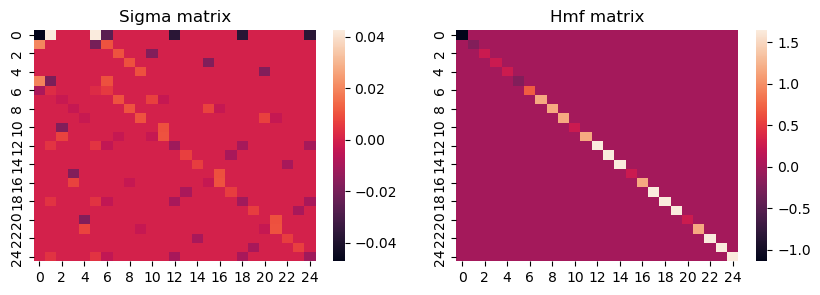

In [430]:
abvmc_eig, dft_eig, d = get_sigma("he-ci.hdf5", res, compare_functional='pbe0')
print('ABVMC', 'LDA', 'PBE0')
for i in range(abvmc_eig.shape[0]):
    abvmc_ref = np.real(abvmc_eig[0])
    dft_ref = dft_eig[0]
    dxc_levels = np.sort(d['xc_levels'])
    xc_ref = dxc_levels[0]
    print(27.211*(np.real(abvmc_eig[i])-abvmc_ref), 27.211*(dft_eig[i]-dft_ref), 27.211*(dxc_levels[i]-xc_ref))

In [420]:
d['xc_energy']

array([[-0.56944682,  0.34851427,  0.82361991,  0.82361991,  0.82361991,
         2.40015106,  3.48358049,  3.48358049,  3.48358049,  3.48358049,
         3.48358049,  4.29074844,  4.29074844,  4.29074844, 11.02146185,
        11.02146185, 11.02146185, 11.02146185, 11.02146185, 11.02146185,
        11.02146185, 12.6180598 , 15.46913017, 15.46913017, 15.46913017,
        15.46913017, 15.46913017, 16.99140201, 16.99140201, 16.99140201],
       [-0.56944682,  0.34851427,  0.82361991,  0.82361991,  0.82361991,
         2.40015106,  3.48358049,  3.48358049,  3.48358049,  3.48358049,
         3.48358049,  4.29074844,  4.29074844,  4.29074844, 11.02146185,
        11.02146185, 11.02146185, 11.02146185, 11.02146185, 11.02146185,
        11.02146185, 12.6180598 , 15.46913017, 15.46913017, 15.46913017,
        15.46913017, 15.46913017, 16.99140201, 16.99140201, 16.99140201]])

In [425]:
d['xc_levels']

[-1.3379897298589927,
 -0.28977540929790957,
 0.2245782124931739,
 0.22457821249318022,
 0.22457821249318055,
 -0.28977540929790957,
 0.7584389112631735,
 1.272792533054257,
 1.2727925330542633,
 1.2727925330542638,
 0.2245782124931739,
 1.272792533054257,
 1.7871461548453405,
 1.7871461548453467,
 1.7871461548453471,
 0.22457821249318022,
 1.2727925330542633,
 1.7871461548453467,
 1.787146154845353,
 1.7871461548453533,
 0.22457821249318055,
 1.2727925330542638,
 1.7871461548453471,
 1.7871461548453533,
 1.7871461548453538]